# Delaunay Triangulation and Voronoi Diagram
In a previous lecture we learned how approximating a nonlinear warp with piecewise linear map can lead to huge gains in efficiency. The next obvious question is how to generate these non-overlapping triangles that cover the entire image. 

One easy option is to divide the image into large squares and then split every square into two triangles. That is adequate for many applications. 

In the applications we are going to discuss, like Face Morphing, Face Averaging and Face Swapping, we need to warp corresponding areas of two different faces. In such cases, the triangulation needs to be based on the the facial landmark points. 

## What is Delaunay Triangulation?

&nbsp;

<center><a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m3-dealunyTriangle-1.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m3-dealunyTriangle-1.png"/></a></center>

**<center>Figure 1. Left : The image with input points shown as red dots. Right: The white lines display Delaunay triangulation calculated using the points. </center>**

Given a set of points in a plane, a triangulation refers to the subdivision of the plane into triangles, with the points as vertices. In Figure 1, we see a set of points on the left image shown using red dots and the triangulation shown using white lines. 

A set of points can have many possible triangulations, but Delaunay triangulation stands out because it has some nice properties. 

In a Delaunay triangulation, triangles are chosen such that **no point is inside the circumcircle of any triangle**. Figure 2. shows Delaunay triangulation of 4 points A, B, C and D.  The difference between the top and the bottom images is that in the top image, point C is further away from line BD as compared to the bottom image. This movement of point C changes the Delaunay triangulation. 

In the top image, for the triangulation to be a valid Delaunay triangulation, point C should be outside the circumcircle of triangle ABD, and point A should be outside the circumcircle of triangle BCD.

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m3-angles.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m3-angles.png"/></a></center>
<center>**Figure 2 : Delaunay triangulation favors small angles**</center>

&nbsp;
An interesting property of Delaunay triangulation is that it does not favor **"skinny"** triangles ( i.e. triangles with one large angle ).

Figure 2 shows how the triangulation changes to pick "fat" triangles when the points are moved. In the top image, the points B and D have their x-coordinates at x = 1.5, and in the bottom image they are moved to the right to x = 1.75. In the top image angles ABC and ABD are large, and Delaunay triangulation creates an edge between B and D splitting the two large angles into smaller angles ABD, ADB, CDB, and CBD. On the other hand in the bottom image, the angle BCD is too large, and Delaunay triangulation creates an edge AC to divide the large angle.

There are many algorithms to find the Delaunay triangulation of a set of points. The most obvious ( but not the most efficient ) one is to start with any triangulation, and check if the circumcircle of any triangle contains another point. If it does, flip the edges ( as shown in Figure 2. ) and continue until there are no triangles whose circumcircle contains a point.

Any discussion on Delaunay triangulation has to include Voronoi diagrams because the Voronoi diagram of a set of points is mathematical dual to its Delaunay triangulation.

## What is a Voronoi Diagram ?

&nbsp;

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m3-voronoiDiagram.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m3-voronoiDiagram.png"/></a></center>


**<center>Figure 3: Left : The image with input points shown as red dots. Right: The Voronoi diagram calculated using the input points.</center>** 


Given a set of points in a plane, a Voronoi diagram partitions the space such that the boundary lines are **equidistant** from neighboring points. Figure 3. shows an example of a Voronoi diagram. You will notice that every boundary line passes through the center of two points. 

>  If you connect the points in neighboring Voronoi regions, you get a Delaunay triangulation!

Given a set of points, you can calculate the Delaunay Triangulation or Voronoi Diagram using the class **Subdiv2D**. Here are the steps. A complete working example is shown in the next section.

## Delaunay Triangulation Code & Tutorial

We will first show a simple code that reads in a file containing points and writes a file containing delaunay triangulation. Each row of the output file contains three numbers corresponding to the three indices of the points that form the triangle. 

In [2]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear' 

The function `findIndex` finds the index of the closest landmark point to the given vertex from the vector of points.

In [4]:
def findIndex(points, point):
  diff = np.array(points) - np.array(point)

  # Find the distance of point from all points
  diffNorm = np.linalg.norm(diff, 2, 1)

  # Find the index with minimum distance and return it
  return np.argmin(diffNorm)

The function `writeDelaunay` gets the Delaunay triangles using the `getTriangleList` method of the `subdiv` object.

`getTriangleList` returns a array of 6 floating point numbers. The six numbers are the x and y coordinates of the three vertices of a triangle.

We are interested in storing the output file as a list of indices of the vertices and not the actual vertices. So, we loop through all the triangles returned by `getTriangleList` and find the index of the vertices.

In [5]:
# write delaunay triangles to file
def writeDelaunay( subdiv, points, outputFileName ) :

    # Obtain the list of triangles.
    # Each triangle is stored as vector of 6 coordinates
    # (x0, y0, x1, y1, x2, y2)
    triangleList = subdiv.getTriangleList();

    filePointer = open(outputFileName,'w')
    
    # Will convert triangle representation to three vertices pt1, pt2, pt3
    for t in triangleList :
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        # Find the landmark corresponding to each vertex
        landmark1 = findIndex(points,pt1)
        landmark2 = findIndex(points,pt2)
        landmark3 = findIndex(points,pt3)
        
        # Each row of the output file contains three
        # number that represent a triangle. 
        # The numbers are the indices of points in the input file.
        filePointer.writelines("{} {} {}\n".
                               format(landmark1, landmark2, landmark3 ))
    filePointer.close()

In [6]:
# Define colors for drawing.
delaunayColor = (255,255,255)
pointsColor = (0, 0, 255)

In [7]:
# Read in the image.
img = cv2.imread(DATA_PATH + "images/smiling-man.jpg")

Delaunay triangulation and voronoi diagrams are calculated using the class `Subdiv2D`. 

`Subdiv2D` is initialized with a rectangle containing all the points. The landmark points are read from the file.

The insert method is used to insert points. 

`writeDelaunay` function uses `getTriangleList` method to get the delaunay triangles.

In [8]:
# Rectangle to be used with Subdiv2D
size = img.shape
rect = (0, 0, size[1], size[0])

# Create an instance of Subdiv2D
subdiv = cv2.Subdiv2D(rect);

# Create an array of points.
points = []

# Read in the points from a text file
with open(DATA_PATH + "images/smiling-man-delaunay.txt") as file :
    for line in file :
        x, y = line.split()
        points.append((int(x), int(y)))

outputFileName = "smiling-man-delaunay.tri"

# Insert points into subdiv
for p in points :
    subdiv.insert(p)

Save output Delaunay triangles to file. The function `writeDelaunay` takes as input an instance of `Subdiv2D`, the list of input points, and saves it to disk.

In [9]:
writeDelaunay(subdiv, points, outputFileName)
print("Writing Delaunay triangles to {}".format(outputFileName))

Writing Delaunay triangles to smiling-man-delaunay.tri


## Delaunay Triangulation Animation Code & Tutorial

It is instructive to see an animation of Delaunay triangulation and Voronoi diagram as the points get added. Let’s dive into the code. 

This function checks if a given point falls inside a rectangle. This is the python counter-part of the OpenCV rect.contains() method provided in C++. 

In [10]:
# Check if a point is inside a rectangle
# Rect is an array of (x, y, w, h)
def rectContains(rect, point) :
  if point[0] < rect[0] :
    return False
  elif point[1] < rect[1] :
    return False
  elif point[0] > rect[2] :
    return False
  elif point[1] > rect[3] :
    return False
  return True

The function drawPoint draws a point on an image using a specified color. 


In [11]:
# Draw a point on the image
def drawPoint(img, p, color ) :
  cv2.circle( img, p, 2, color, -1, cv2.LINE_AA, 0 )

The function drawDelaunay draws Delaunay triangles on an image using a specified color. 

Points are inserted using an instance of Subdiv2D before calling this function. Delaunay triangles are obtained by calling the method getTriangleList.

Once we get the triangles, we draw the lines by going over each vertex of the triangle.

In [12]:
# Draw delaunay triangles
def drawDelaunay(img, subdiv, delaunayColor ) :

  # Obtain the list of triangles.
  # Each triangle is stored as vector of 6 coordinates
  # (x0, y0, x1, y1, x2, y2)
  triangleList = subdiv.getTriangleList();
  size = img.shape
  r = (0, 0, size[1], size[0])

  # Will convert triangle representation to three vertices pt1, pt2, pt3
  for t in triangleList :
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])
    
    # Draw triangles that are completely inside the image
    if rectContains(r, pt1) and rectContains(r, pt2) and rectContains(r, pt3) :
      cv2.line(img, pt1, pt2, delaunayColor, 1, cv2.LINE_AA, 0)
      cv2.line(img, pt2, pt3, delaunayColor, 1, cv2.LINE_AA, 0)
      cv2.line(img, pt3, pt1, delaunayColor, 1, cv2.LINE_AA, 0)

The function drawVoronoi draws Voronoi diagrams on an image. 

Points are inserted using an instance of Subdiv2D before calling this function. The Voronoi diagram is represented as a collection of facets (polygons) which can be obtained using the the method getVoronoiFacetList.

The facets so obtained are drawn on the image using fillConvexPoly and the boundaries of the facets are drawn using polylines.

In [13]:
# Draw voronoi diagram
def drawVoronoi(img, subdiv) :

  # Get facets and centers
  ( facets, centers) = subdiv.getVoronoiFacetList([])

  for i in range(0,len(facets)) :
    ifacetArr = []
    for f in facets[i] :
      ifacetArr.append(f)
    
    # Extract ith facet
    ifacet = np.array(ifacetArr, np.int)

    # Generate random color
    color = (random.randint(0, 255), 
            random.randint(0, 255), 
            random.randint(0, 255))

    # Fill facet with a random color
    cv2.fillConvexPoly(img, ifacet, color, cv2.LINE_AA, 0);
    
    # Draw facet boundary
    ifacets = np.array([ifacet])
    cv2.polylines(img, ifacets, True, (0, 0, 0), 1, cv2.LINE_AA, 0)

    # Draw centers.
    cv2.circle(img, (centers[i][0], centers[i][1]), 
                3, (0, 0, 0), -1, cv2.LINE_AA, 0)

The function findIndex and writeDelaunay were discussed above.

In [14]:
# Rectangle to be used with Subdiv2D
size = img.shape
rect = (0, 0, size[1], size[0])

The image bounding box is used to initialize an instance of Subdiv2D. The points are subsequently added to this object for calculating and displaying Delaunay triangulation and Voronoi diagrams.

In [15]:
# Create an instance of Subdiv2D
subdiv = cv2.Subdiv2D(rect);

# Create an array of points.
points = [];

# Allocate space for voronoi Diagram
imgVoronoi = np.zeros(img.shape, dtype = img.dtype)

# Read in the points from a text file
with open(DATA_PATH + "images/smiling-man-delaunay.txt") as file :
    for line in file :
        x, y = line.split()
        points.append((int(x), int(y)))

outputFileName = "smiling-man-delaunay.tri"

# Draw landmark points on the image
for p in points :
    drawPoint(img, p, pointsColor )

We calculate and draw the Delaunay triangulation ( on imgDelaunay ) and Voronoi Diagram on ( imgVoronoi ) every time a new point is added thus creating an animation. 

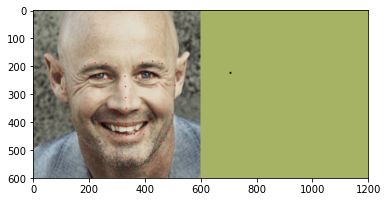

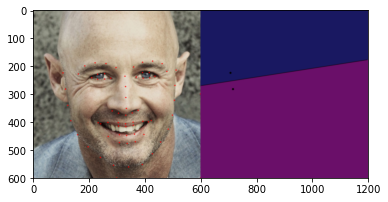

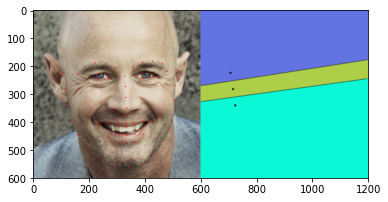

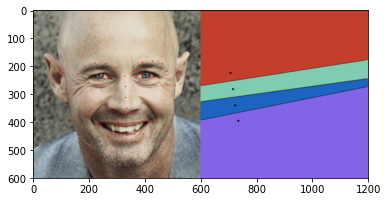

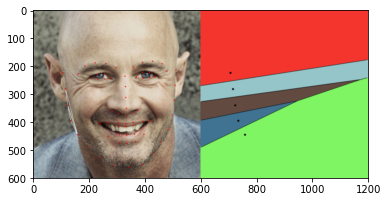

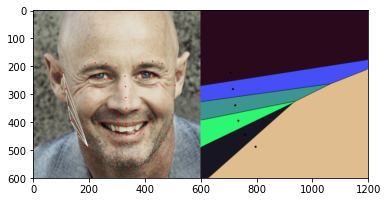

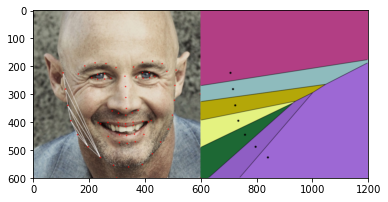

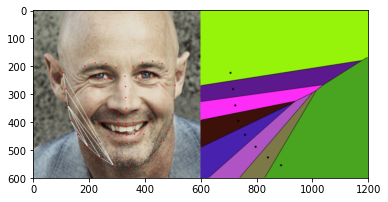

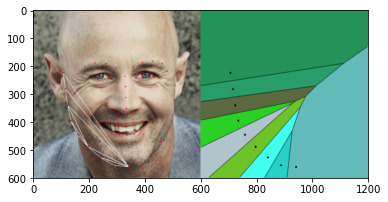

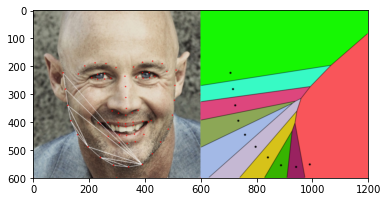

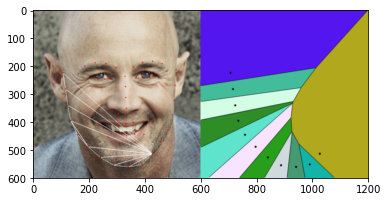

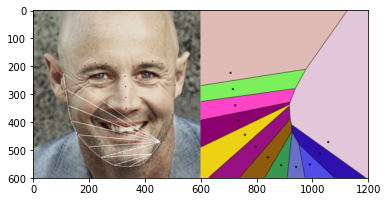

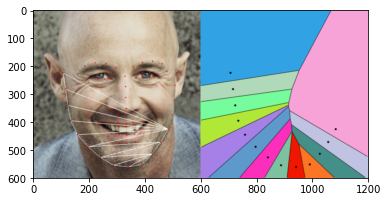

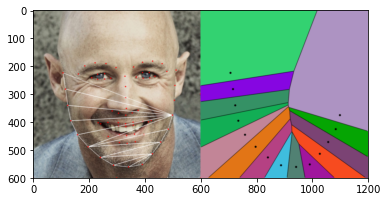

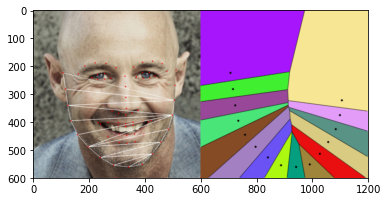

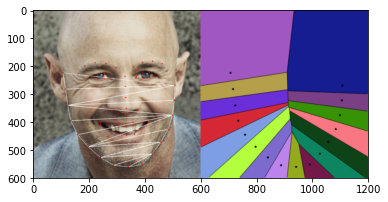

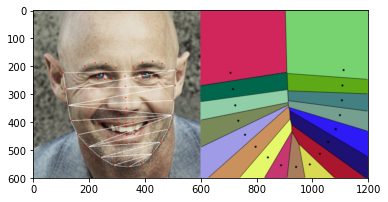

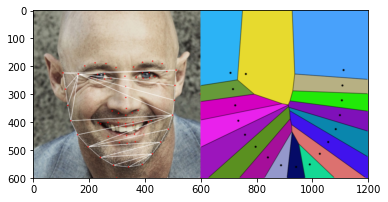

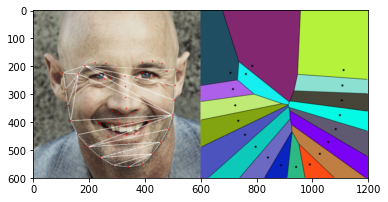

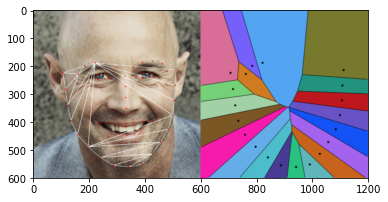

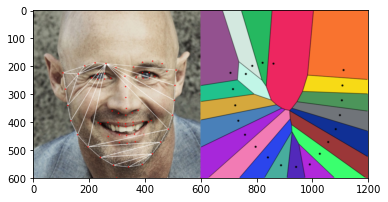

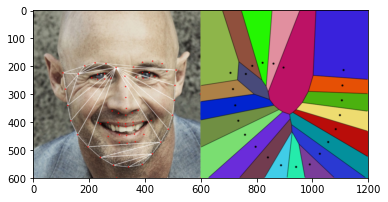

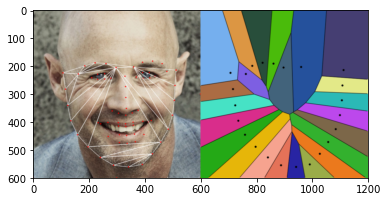

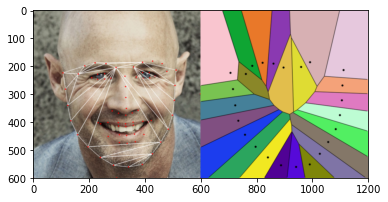

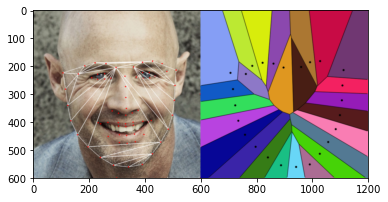

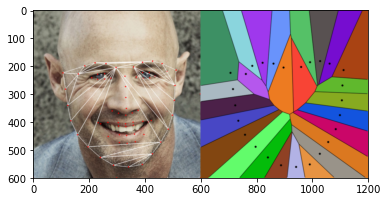

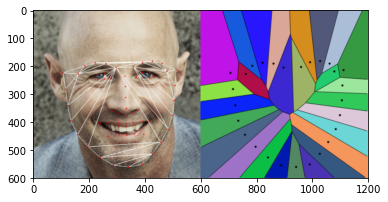

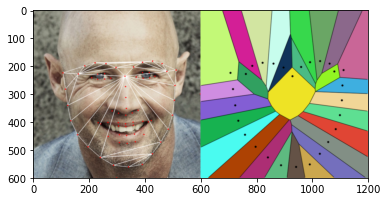

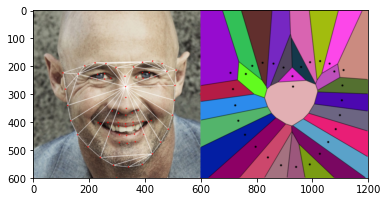

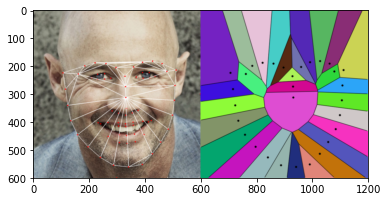

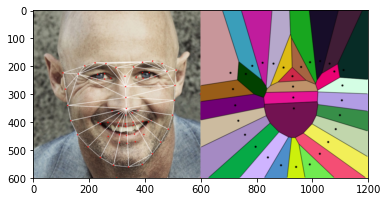

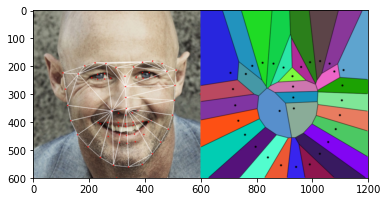

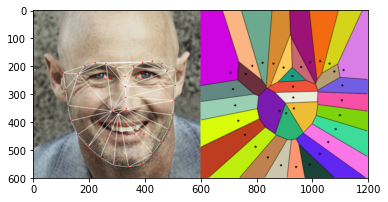

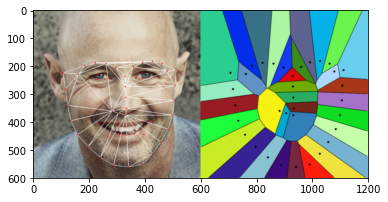

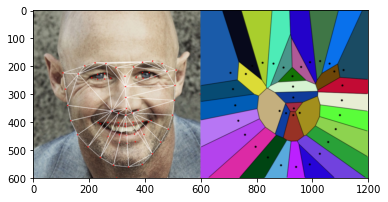

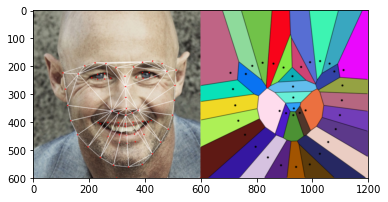

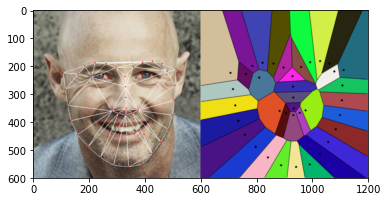

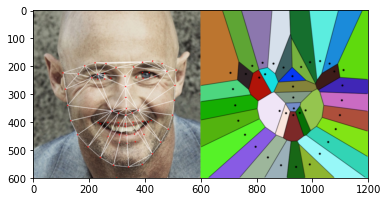

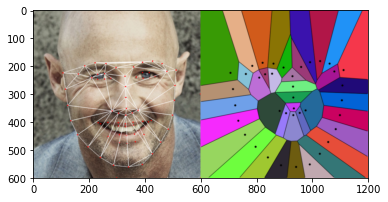

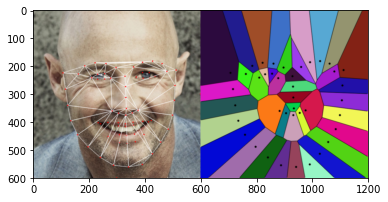

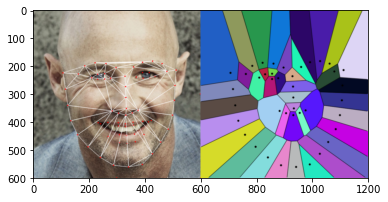

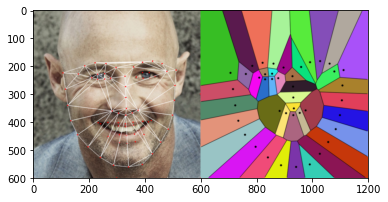

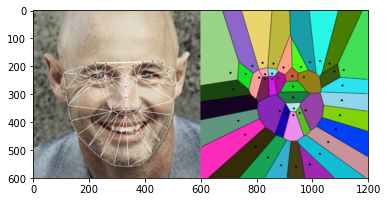

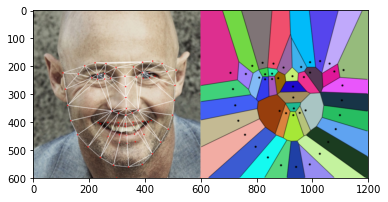

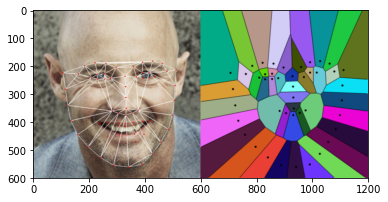

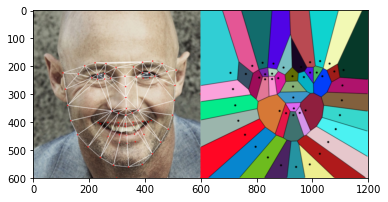

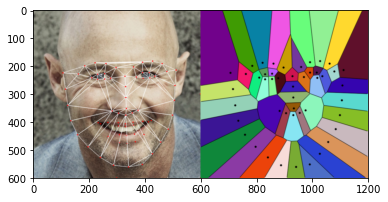

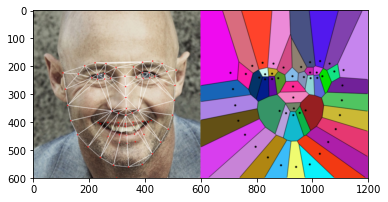

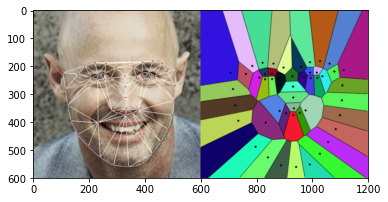

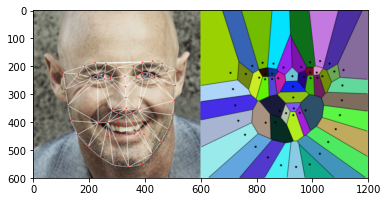

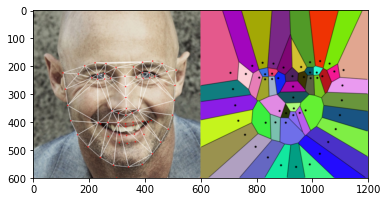

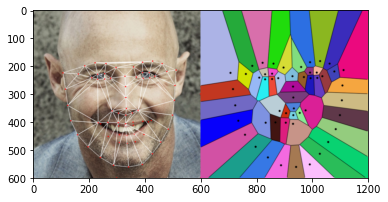

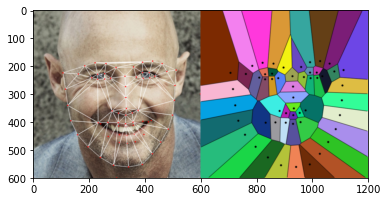

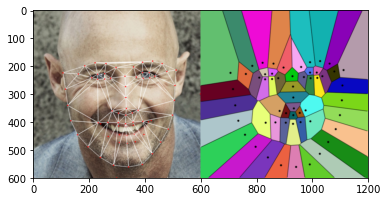

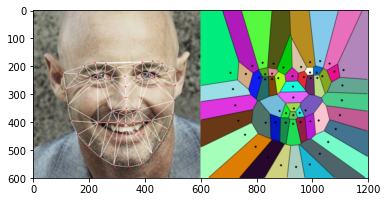

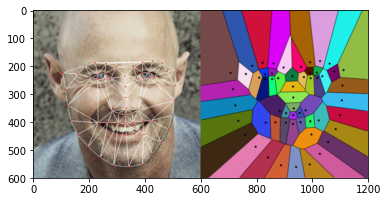

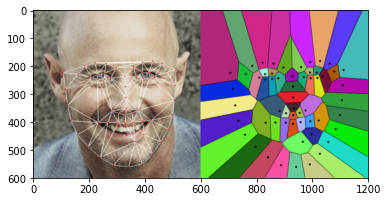

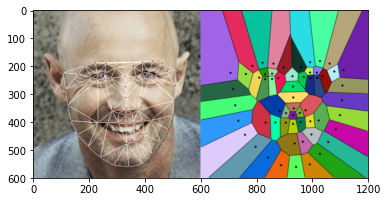

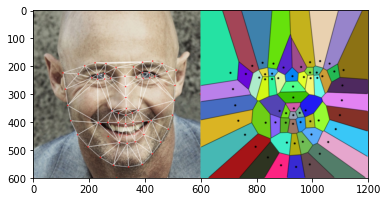

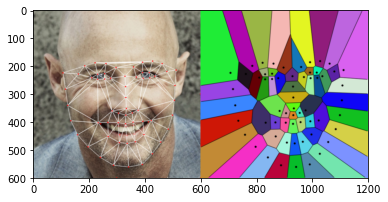

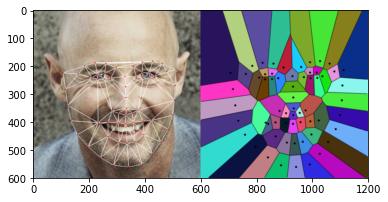

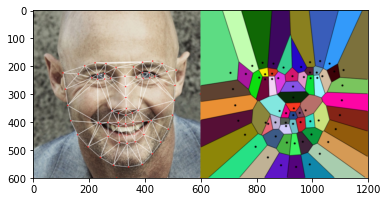

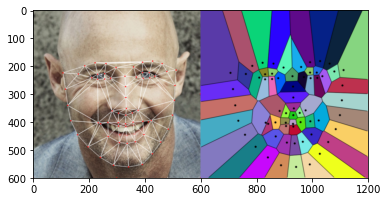

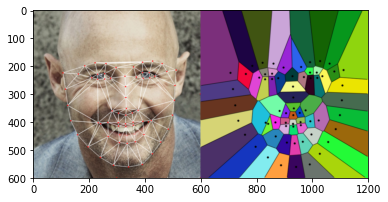

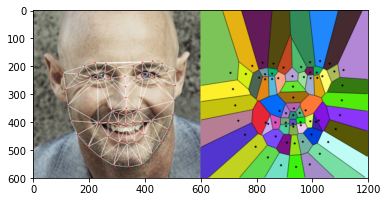

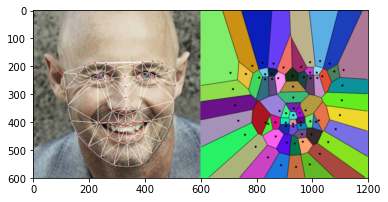

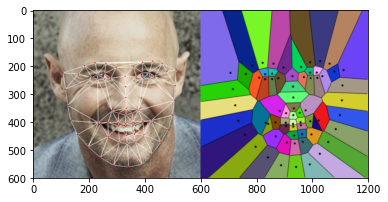

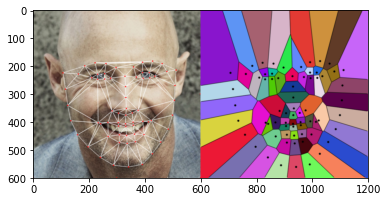

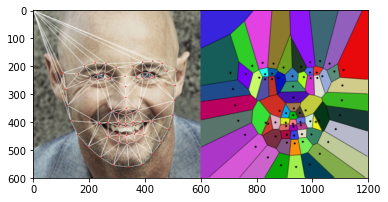

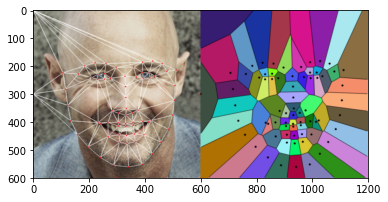

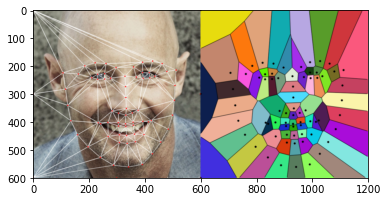

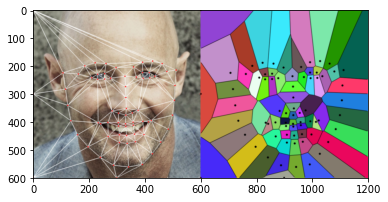

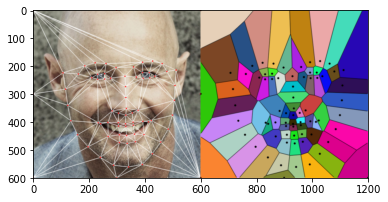

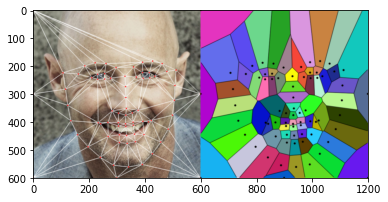

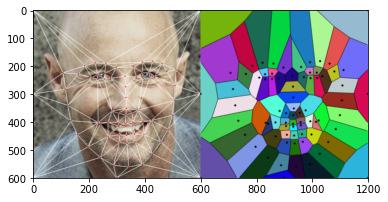

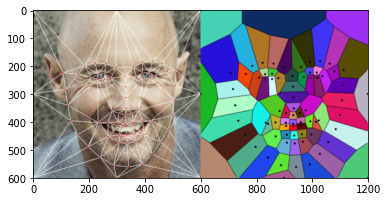

Writing Delaunay triangles to smiling-man-delaunay.tri


In [16]:
# Insert points into subdiv
plotPoints = []

for p in points :
    subdiv.insert(p)
    plotPoints.append(p)

    imgDelaunay = img.copy()

    # Draw delaunay triangles and voronoi diagrams
    drawDelaunay(imgDelaunay, subdiv, delaunayColor);
    drawVoronoi(imgVoronoi,subdiv)

    for pp in plotPoints :
        drawPoint(imgDelaunay, pp, pointsColor)

    # Display as an animation
    imgDisplay = np.hstack([imgDelaunay, imgVoronoi])
    plt.imshow(imgDisplay[:,:,::-1])
    plt.show()
    
writeDelaunay(subdiv, points, outputFileName)
print("Writing Delaunay triangles to {}".format(outputFileName))

# References and Further Reading

[https://en.wikipedia.org/wiki/Delaunay_triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation)